<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53973 entries, 0 to 53972
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   business_id            53973 non-null  int64  
 1   business_name          53973 non-null  object 
 2   business_address       53973 non-null  object 
 3   business_city          53973 non-null  object 
 4   business_state         53973 non-null  object 
 5   business_postal_code   52787 non-null  object 
 6   business_latitude      27475 non-null  float64
 7   business_longitude     27475 non-null  float64
 8   business_location      27460 non-null  object 
 9   business_phone_number  17672 non-null  float64
 10  inspection_id          53973 non-null  object 
 11  inspection_date        53973 non-null  object 
 12  inspection_score       39541 non-null  float64
 13  inspection_type        53973 non-null  object 
 14  violation_id           40253 non-null  object 
 15  vi

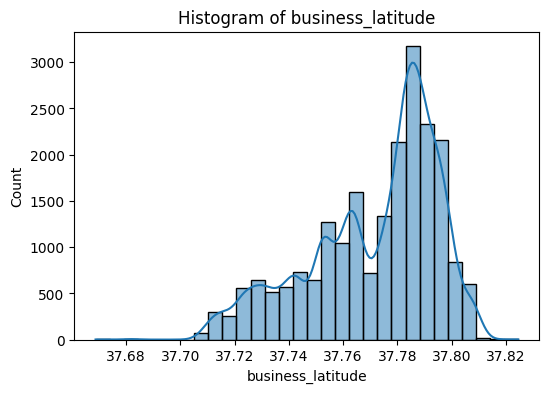


  Analysis for business_latitude  
Max:    37.82
Min:    37.67
Mean:   37.77
Median: 37.78
Outliers (IQR method): 10 (0.05% of data)
------------------------------


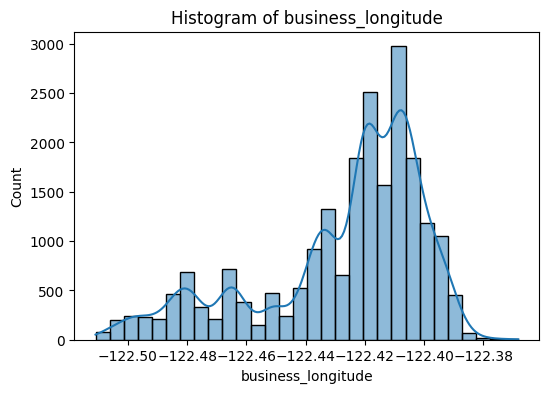


  Analysis for business_longitude  
Max:    -122.37
Min:    -122.51
Mean:   -122.43
Median: -122.42
Outliers (IQR method): 1385 (6.43% of data)
------------------------------


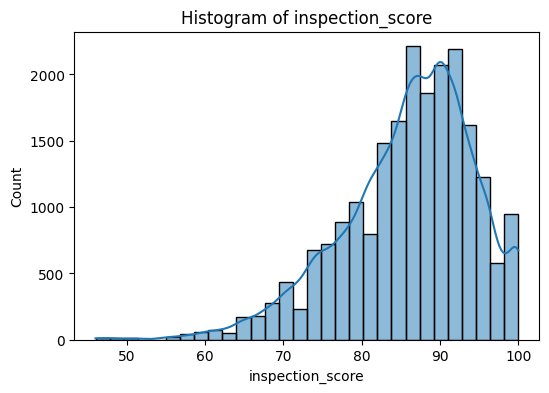


  Analysis for inspection_score  
Max:    100.00
Min:    46.00
Mean:   86.01
Median: 87.00
Outliers (IQR method): 331 (1.54% of data)
------------------------------


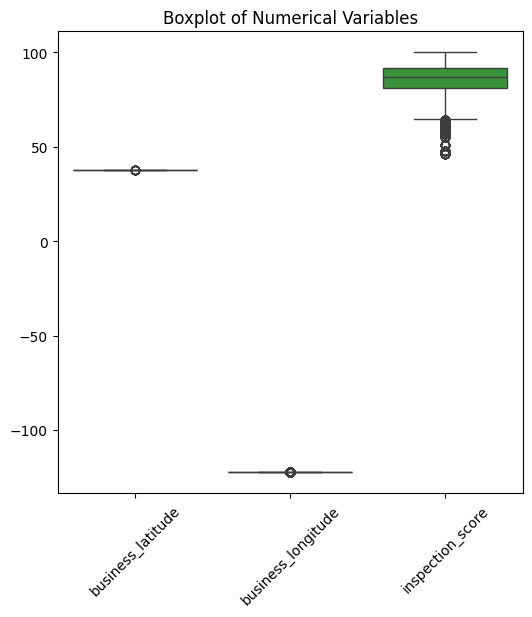

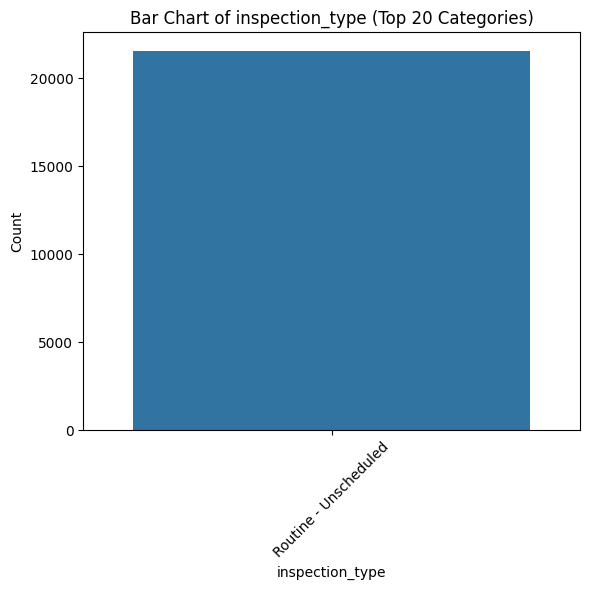

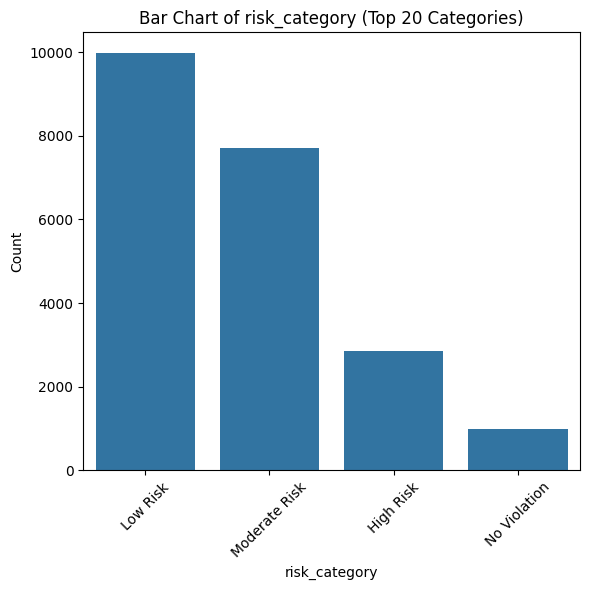

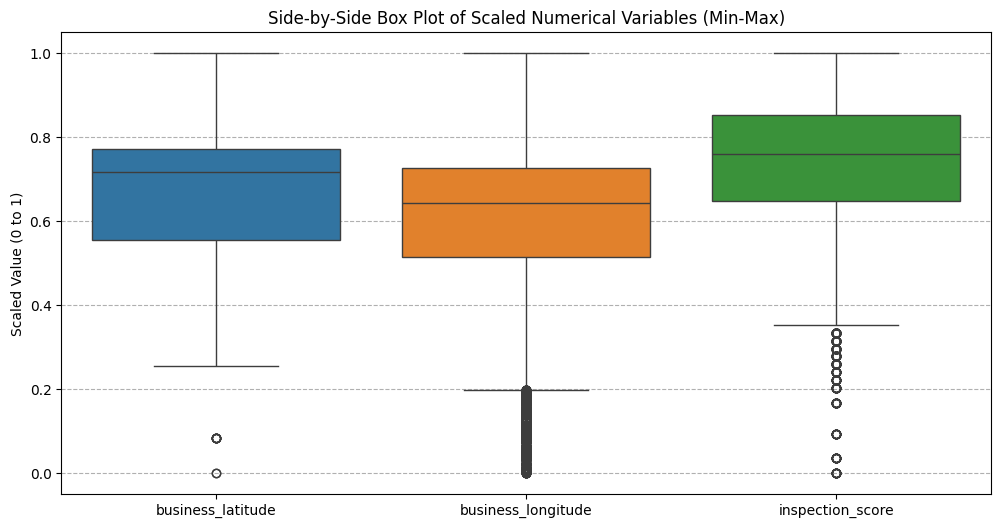

The plot shows the distribution of each numerical variable (latitude, longitude, and inspection score) after scaling them to a 0-to-1 range.
The 'inspection_score' distribution (after scaling) appears the tightest, with its median closest to 0.75, indicating most scores are in the higher range.
The large whiskers and numerous outliers in 'business_latitude' and 'business_longitude' are likely due to the remaining missing values (which are NaN and not fully scaled/removed), or actual geographic outliers.


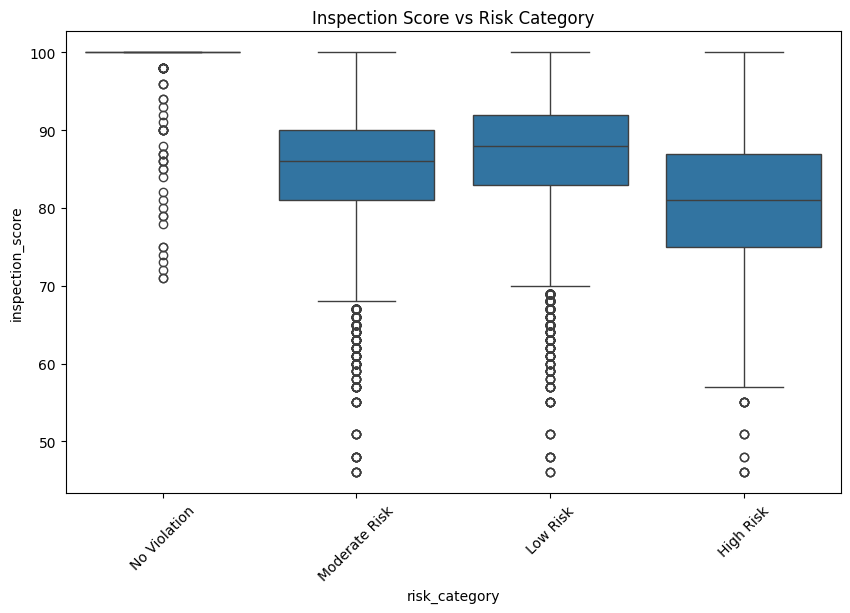

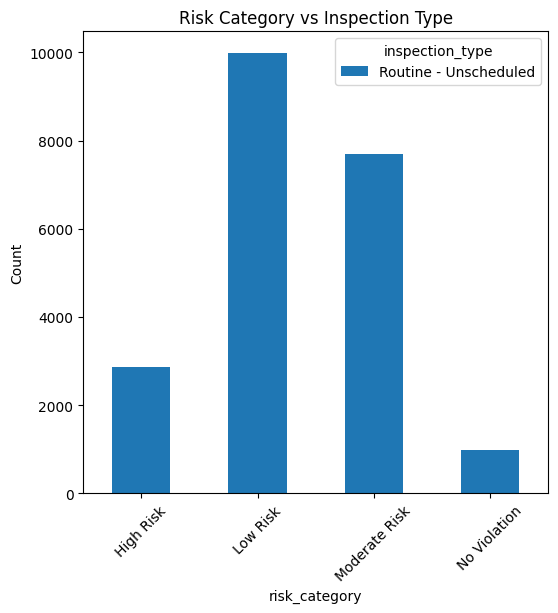

<Figure size 800x800 with 0 Axes>

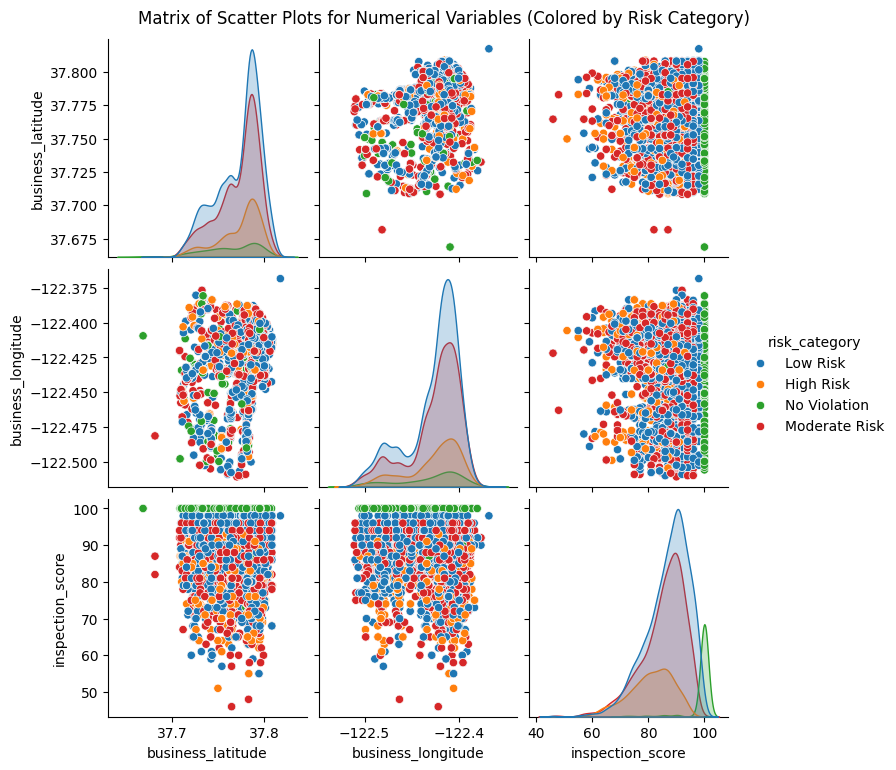

The diagonal plots show the distribution of each variable. The off-diagonal plots show the scatter relationship between pairs.
there are clusters showing physical location density and correlations in Inspection Score vs. Location.


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('Health_Inspection_Scores_(2016-2019)_20251012.csv')
df.head()
df.info()
df.describe()

df.fillna({'business_postal_code': df['business_postal_code'].mode()[0]}, inplace=True)


df.drop(columns=['business_phone_number'], inplace=True)

# violation-related missing values with "No Violation"
df['violation_id'] = df['violation_id'].fillna('No Violation')
df['violation_description'] = df['violation_description'].fillna('No Violation')
df['risk_category'] = df['risk_category'].fillna('No Violation')

df = df.dropna(subset=['business_latitude', 'business_longitude', 'business_location'])
df = df.dropna(subset=['inspection_score'])

num_cols = ['business_latitude', 'business_longitude', 'inspection_score']
#check
print(df[num_cols].describe())


for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


    print(f"\n  Analysis for {col}  ")
    
    col_stats = df[col].agg(['max', 'min', 'mean', 'median']).to_dict()
    print(f"Max:    {col_stats['max']:.2f}")
    print(f"Min:    {col_stats['min']:.2f}")
    print(f"Mean:   {col_stats['mean']:.2f}")
    print(f"Median: {col_stats['median']:.2f}")

    # Outlier
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col].count()
    print(f"Outliers (IQR method): {outliers} ({outliers/len(df):.2%} of data)")
    print("-" * 30)

plt.figure(figsize=(6,6))
sns.boxplot(data=df[num_cols])
plt.title('Boxplot of Numerical Variables')
plt.xticks(rotation=45)
plt.show()

categorical_cols = ['business_city', 'inspection_type', 'risk_category']

for col in categorical_cols:
    plt.figure(figsize=(6, 6))

    top_counts = df[col].value_counts().head(20)
    
    sns.barplot(x=top_counts.index, y=top_counts.values)
    plt.title(f'Bar Chart of {col} (Top 20 Categories)')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

df_scaled = df[num_cols].copy()

for col in num_cols:
    min_val = df_scaled[col].min()
    max_val = df_scaled[col].max()
    
    
    if max_val != min_val:
        df_scaled[col] = (df_scaled[col] - min_val) / (max_val - min_val)
    else:
        df_scaled[col] = 0 


plt.figure(figsize=(12, 6))
sns.boxplot(data=df_scaled)
plt.title('Side-by-Side Box Plot of Scaled Numerical Variables (Min-Max)')
plt.ylabel('Scaled Value (0 to 1)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()


print("The plot shows the distribution of each numerical variable (latitude, longitude, and inspection score) after scaling them to a 0-to-1 range.")
print("The 'inspection_score' distribution (after scaling) appears the tightest, with its median closest to 0.75, indicating most scores are in the higher range.")
print("The large whiskers and numerous outliers in 'business_latitude' and 'business_longitude' are likely due to the remaining missing values (which are NaN and not fully scaled/removed), or actual geographic outliers.")

plt.figure(figsize=(10,6))
sns.boxplot(x='risk_category', y='inspection_score', data=df)
plt.xticks(rotation=45)
plt.title('Inspection Score vs Risk Category')
plt.show()

pd.crosstab(df['risk_category'], df['inspection_type']).plot(kind='bar', stacked=True, figsize=(6,6))
plt.title('Risk Category vs Inspection Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 8))
sns.pairplot(df.sample(n=5000, random_state=42),  
             vars=num_cols, 
             hue='risk_category',
             diag_kind='kde') 
plt.suptitle('Matrix of Scatter Plots for Numerical Variables (Colored by Risk Category)', y=1.02)
plt.show()


print("The diagonal plots show the distribution of each variable. The off-diagonal plots show the scatter relationship between pairs.")
print("there are clusters showing physical location density and correlations in Inspection Score vs. Location.")